In this Kernel I'd like to share a couple of ideas which I found on Kernels myself:
 - adversarial validation
 - shakeup simulation

Originals where I've first seen these ideas implemented:
 - [Quora adversarial validation](https://www.kaggle.com/tunguz/quora-adversarial-validation) by Bojan Tunguz
 - [Quora shake-up simulation](https://www.kaggle.com/c/quora-insincere-questions-classification/discussion/78952#463246) by some other master
 
##  Adversarial validation
 
The idea of adversarial validation is to forget targets at all, concatenate training and test features, and label train instances with 1s and test instances - with 0s. Then we perform cross-validation, and finally see whether a model can distinguish train from test (if in such classification setting scores are pretty high) or not. 
 - In the first case we can identify features (via weights/feature importances) which help to distinguish train from test. Such features are "suspicious" - their distribution has most likely changes in the test set as compared to the training set. These features deserve special investigation (see [this example](https://www.kaggle.com/tunguz/ms-malware-adversarial-validation), again by Bojan Tunguz, from that funny [MS malware competition](https://www.kaggle.com/c/microsoft-malware-prediction/))
 - In the second case the model can not distinguish train from test just based on the provided features, that's a good sign

In [19]:
import os
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
import warnings
warnings.filterwarnings('ignore')


In [2]:
PATH_TO_DATA = '../input/'

df_train_features = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                             'train_features.csv'), 
                                    index_col='match_id_hash')
df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_features.csv'), 
                                   index_col='match_id_hash')

We concatenate training and test sets, only features, no targets whatsoever.

In [3]:
df = pd.concat([df_train_features, df_test_features])

New target is just a binary feature indicating training instances:

In [4]:
is_train = [1] * len(df_train_features) + [0] * len(df_test_features)

Grab just basic RF model and perform 5-fold cross-validation.

In [5]:
model = RandomForestClassifier(n_estimators=100, n_jobs=4, random_state=17)

In [6]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

In [7]:
%%time
adv_validation_scores = cross_val_score(model, df, is_train, cv=skf, n_jobs=4,
                                       scoring='roc_auc')

CPU times: user 925 ms, sys: 208 ms, total: 1.13 s
Wall time: 45.5 s


We see "nice" AUCs around 51-52%. So the model doesn't distinguish train and test. That's good! So distributions of basic features that we've passed into the model are pretty much the same in training and test sets. 

In [8]:
adv_validation_scores

array([0.51309931, 0.51566134, 0.51133686, 0.51175252, 0.51929953])

Feature importance doesn't surprise at all. However, in case of high adversarial validation scores do explore it carefully. 

In [9]:
model.fit(df, is_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=4,
            oob_score=False, random_state=17, verbose=0, warm_start=False)

In [10]:
import eli5

In [11]:
eli5.show_weights(estimator=model, feature_names=list(df.columns))

Weight,Feature
0.0075 ± 0.0027,d2_hero_id
0.0074 ± 0.0026,d5_hero_id
0.0073 ± 0.0025,d1_hero_id
0.0073 ± 0.0025,d3_hero_id
0.0073 ± 0.0026,r2_hero_id
0.0072 ± 0.0026,r3_hero_id
0.0072 ± 0.0027,d3_max_mana
0.0072 ± 0.0030,r2_max_mana
0.0072 ± 0.0028,d4_hero_id
0.0070 ± 0.0028,r4_hero_id


## Shake-up simulation

Oh, it's just a fancy name for repeated validation where holdout size is equal to the test size in our competition. You split the training set (now with original targets, forget about adversarial validation) randomly multiple times (`sklearn.model_selection.StratifiedShuffleSplit`), setting test_size to be 10k in our case, and collect statistics about the distribution of these holdout scores. In such a way you can sort of estimate the degree of a possible shake-up (i.e., variation in private LB scores). 

In [12]:
from sklearn.model_selection import StratifiedShuffleSplit


In [13]:
skf = StratifiedShuffleSplit(n_splits=150, test_size=10000, random_state=1)

Now we actually need original targets.

In [14]:
df_train_targets = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                            'train_targets.csv'), 
                                   index_col='match_id_hash')

In [15]:
%%time
# scores = cross_val_score(model, df_train_features, df_train_targets['radiant_win'], 
#                          cv=skf, n_jobs=4, scoring='roc_auc')


CPU times: user 26.9 s, sys: 2.51 s, total: 29.4 s
Wall time: 10min


In [16]:
scores = pd.Series(scores)
mean = scores.mean()
lower, upper = mean - 2 * scores.std(), mean + 2 * scores.std()

In [17]:
from matplotlib import pyplot as plt
import seaborn as sns

Plot the distribution of validation scores.

/Users/mikhail/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


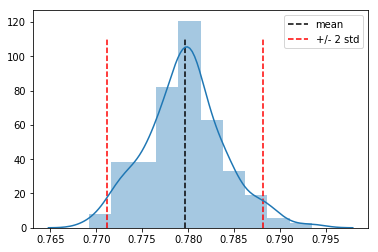

In [18]:
sns.distplot(scores, bins=10);
plt.vlines(x=[mean], ymin=0, ymax=110, 
           label='mean', linestyles='dashed');
plt.vlines(x=[lower, upper], ymin=0, ymax=110, 
           color='red', label='+/- 2 std',
          linestyles='dashed');
plt.legend();

Looks like variations up to +/- 0.01 AUC are expected.

So here we've covered two interesting validation hacks. Maybe they are not extremely useful in the DotA 2 winner prediction competition, but at least the techniques are interesting and it's good to know them.